Requires all results from [`./segmentation/`](./segmentation/) and notebook 2 and OC_per_seg_corrections.

In [1]:
suppressPackageStartupMessages({
  library(cellAdmix)
  library(cowplot)
  library(dataorganizer)
  library(ggplot2)
  library(magrittr)
  library(Matrix)
  library(readr)
  library(Seurat)
})

devtools::load_all()

theme_set(theme_bw())

ℹ Loading cellAdmixNotebooks


In [2]:
MIN_MOLS_PER_CELL <- 25

## Load data

In [3]:
df_raw <- DatasetPath('human_ovarian_cancer', 'transcripts.parquet') %>%
    arrow::read_parquet()

Original (Xenium)

In [4]:
so <- DatasetPath('human_ovarian_cancer', 'processed', 'so.rds') %>% read_rds()
dim(so)

[1]   5101 373830

Baysor:

In [5]:
baysor_cm <- DatasetPath('human_ovarian_cancer', 'seg_method_results', 'baysor', 'segmentation_counts') %>%
    Seurat::Read10X(gene.column=1)

BIDCell

In [6]:
bidcell_cm <- DatasetPath(
  'human_ovarian_cancer', 'seg_method_results', 'bidcell', 'cell_gene_matrices',
  '2025_01_16_22_15_56', 'expr_mat.csv'
) %>% data.table::fread() %>% .[,3:ncol(.)] %>% as.matrix() %>% as('CsparseMatrix') %>% t()

colnames(bidcell_cm) <- 1:ncol(bidcell_cm)

ProSeg

In [7]:
proseg_tx <- DatasetPath('human_ovarian_cancer','seg_method_results','proseg', 'transcript-metadata.csv.gz') %>%
  read_csv(show_col_types=FALSE)

In [9]:
proseg_tx <- as.data.frame(proseg_tx)
ndx_change <- which(colnames(proseg_tx)=='assignment')
colnames(proseg_tx)[ndx_change] <- 'cell'

proseg_tx <- proseg_tx[proseg_tx$cell!=4294967295,]

gene.factors <- factor(proseg_tx$gene)
cell.factors <- factor(proseg_tx$cell)

proseg_cm <- Matrix::sparseMatrix(
  i = as.integer(gene.factors),  # Now rows are genes
  j = as.integer(cell.factors),  # And columns are cells
  x = rep(1, nrow(proseg_tx)),      # Each row in `tx.dat` contributes 1 count
  dims = c(length(levels(gene.factors)), length(levels(cell.factors))),
  dimnames = list(
    levels(gene.factors),        # Row names (gene names)
    levels(cell.factors)         # Column names (cell names)
  )
)

## Prepare data

In [10]:
cms <- list(
    Baysor=baysor_cm,
    BIDCell=bidcell_cm,
    ProSeg=proseg_cm,
    Xenium=so[['RNA']]$counts
)

cms %<>% lapply(\(cm) cm[, (colSums(cm) >= MIN_MOLS_PER_CELL)])

for (n in names(cms)) {
    colnames(cms[[n]]) %<>% {paste0(n, '_', .)}
}

In [11]:
palette <- c(
    Baysor='#F8766D', BIDCell='#00BA38', ProSeg='#D39200', scRNAseq='#888888', Xenium='#FF61C3'
)

plot_theme <- theme(axis.text.x=element_text(angle=45, hjust=1))

## Basic parameters

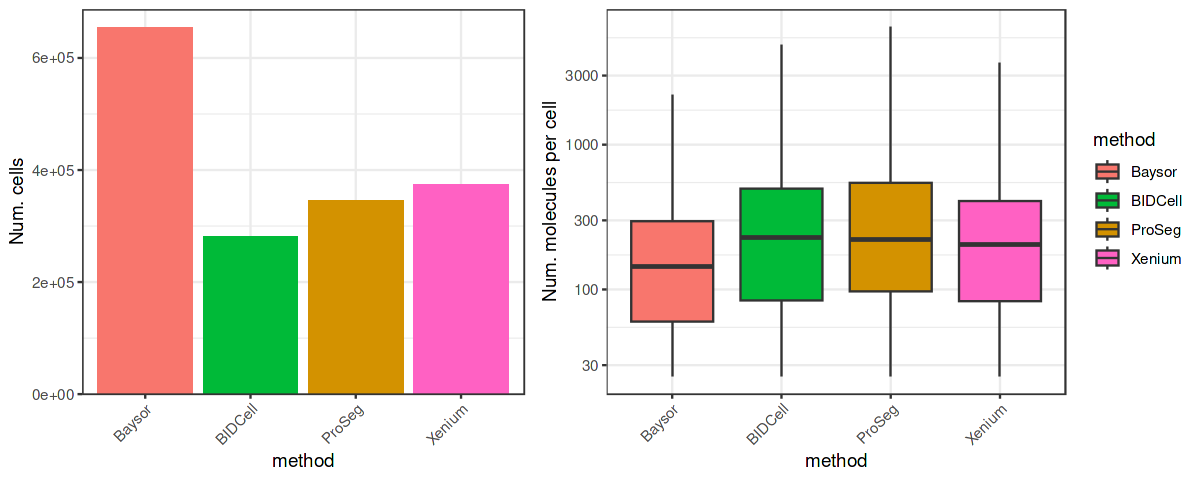

In [12]:
options(repr.plot.width=10, repr.plot.height=4)

n_cells <- sapply(cms, ncol) %>% data.frame(method=names(.), n_cells=.)

n_mols_per_cell <- names(cms) %>%
    lapply(\(n) data.frame(method=n, n_mols=colSums(cms[[n]]))) %>%
    bind_rows()

gg1 <- ggplot(n_cells) +
    geom_col(aes(x=method, y=n_cells, fill=method)) +
    ylab('Num. cells') +
    scale_y_continuous(expand=c(0, 0, 0.05, 0)) +
    theme(legend.position="none") +
    scale_fill_manual(values=palette) +
    plot_theme

gg2 <- ggplot(n_mols_per_cell) +
    geom_boxplot(aes(x=method, y=n_mols, fill=method)) +
    scale_y_log10(n.breaks=6) +
    ylab('Num. molecules per cell') +
    scale_fill_manual(values=palette) +
    plot_theme

plot_grid(gg1, gg2, rel_widths=c(0.8, 1))

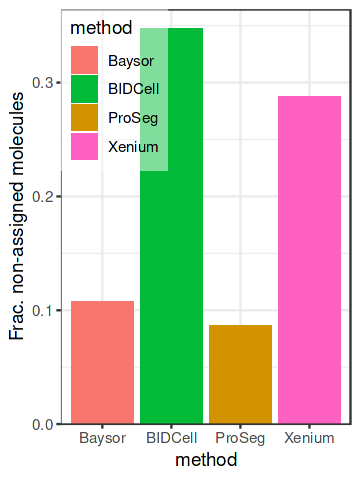

In [13]:
options(repr.plot.width=3, repr.plot.height=4)

noise_fracs <- sapply(cms, sum) %>% {1 - . / nrow(df_raw)} %>%
    {data.frame(method=names(.), frac=.)}

ggplot(noise_fracs) +
    geom_col(aes(x=method, y=frac, fill=method)) +
    ylab('Frac. non-assigned molecules') +
    scale_y_continuous(expand=c(0, 0, 0.05, 0)) +
    theme_legend(position=c(0, 1)) +
    scale_fill_manual(values=palette)

## Annotation transfer

In [14]:
shared_genes <- sapply(cms, rownames) %>% Reduce(intersect, .)

In [15]:
cm_joint <- cms %>% lapply(`[`, shared_genes,) %>% Reduce(cbind, .)
dim(cm_joint)

[1]    4912 1654890

In [16]:
so_joint <- cm_joint %>%
    CreateSeuratObject() %>%
    process_seurat(build.knn=FALSE)

so_joint$sample <- strsplit(colnames(so_joint), '_') %>% sapply(`[[`, 1)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  DCN, MYH11, LUM, BGN, C7, C11orf96, COL5A1, POSTN, CNN1, CCN1 
	   CDKN1A, THY1, CXCL12, COL5A2, SFRP4, NR4A1, CTHRC1, THBS2, TIMP3, CDH11 
	   C4B, PDGFRB, CCND2, AEBP1, AQP1, MMP14, ADGRA2, SNAI2, COL11A1, SLC2A3 
Negative:  CD47, LAPTM4B, UCHL1, EPCAM, YWHAZ, CP, HMGA1, PLXNB1, HSPE1, TOP2A 
	   SMC4, MLF1, TPX2, LCN2, BIRC5, MAL2, TFRC, IFT57, MUC16, CSE1L 
	   CCNE1, ALCAM, MYBL2, CENPF, DSG2, STMN1, DHCR24, RUVBL1, IL1RAP, SOX17 
PC_ 2 
Positive:  COL5A1, LUM, BGN, COL5A2, CTHRC1, MMP14, THBS2, THY1, COL11A1, CDH11 
	   LOXL1, PLAU, DCN, INHBA, POSTN, SERPINH1, ADAMTS14, FAP, COL4A1, LTBP2 
	   CXCL12, ADAM12, SERPINE1, LOX, TIMP3, MMP11, CCN4, THBS1, NBL1, COL10A1 
Negative:  MYH11, CNN1, CP, MUC16, RGL3, CYP4B1, PLXNB1, CD47, C2orf88, EPCAM 
	   FAM107A, LCN2, KCNC3, ADAMTS1, SYNPO2, PLN, PCP2, MAL2, SYNM, KCNK15 
	   UGT2B7, SCNN1A, MAPK15, GRIA2, RBM38, 

In [17]:
so_joint$cell_type <- NA
so_joint$cell_type[paste0('Xenium_', colnames(so))] <- adjust_gut_cell_types(so$cell_type_full)

cell_types <- Embeddings(so_joint, 'pca') %>%
  transfer_annotation_knn(so_joint$cell_type, ref.prefix='Xenium_')

so_joint$cell_type[names(cell_types)] <- cell_types

In [19]:
write_rds(cell_types, CachePath('oc_seg_annot_transfer5.rds'))

## Doublet scoring

In [20]:
so_rna <- DatasetPath('human_ovarian_cancer_rna', 'processed', 'so.rds') %>% readRDS()
so_rna

An object of class Seurat 
18082 features across 15372 samples within 1 assay 
Active assay: RNA (18082 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [21]:
sos <- so_joint %>% SplitObject(split.by='sample')
so_rna$cell_type <- so_rna$cell_type_full
sos$scRNAseq <- so_rna

In [22]:
common_cell_types <- lapply(sos, \(so) unique(so$cell_type)) %>%
    Reduce(intersect, .) %>% setdiff('Other')
lapply(sos, \(so) setdiff(unique(so$cell_type), common_cell_types))

$Baysor
[1] "SOX2-OT+ Tumor Cells"

$BIDCell
[1] "SOX2-OT+ Tumor Cells"

$ProSeg
[1] "SOX2-OT+ Tumor Cells"

$Xenium
[1] "SOX2-OT+ Tumor Cells"

$scRNAseq
[1] "MT-High, Jun+/Fos+ Tumor Cells"

In [23]:
common_cell_types
length(common_cell_types)

[1] "Tumor Cells"                    "Smooth Muscle Cells"           
 [3] "Tumor Associated Fibroblasts"   "Macrophages"                   
 [5] "Stromal Associated Fibroblasts" "T & NK Cells"                  
 [7] "Pericytes"                      "Endothelial Cells"             
 [9] "Proliferative Tumor Cells"      "Malignant Cells Lining Cyst"   
[11] "Ciliated Epithelial Cells"      "VEGFA+ Tumor Cells"            
[13] "Fallopian Tube Epithelium"      "Granulosa Cells"               
[15] "Inflammatory Tumor Cells"

[1] 15

In [24]:
sos %<>% lapply(\(so) subset(so, cells=colnames(so)[so$cell_type %in% unique(common_cell_types)]))

### Estimate adjacency

In [25]:
df_spatial <- df_raw %>% as_tibble() %>%
    rename(x=x_location, y=y_location, z=z_location, gene=feature_name) %>%
    mutate(cell=as.character(cell_id), cell_type=so$cell_type_full[cell]) %>%
    filter(!is.na(cell_type))

nrow(df_spatial)

[1] 129829846

In [26]:
df_spatial <- df_spatial[df_spatial$cell_type %in% common_cell_types,]

In [27]:
cell_adj_df <- estimate_cell_adjacency(df_spatial, random.shift=1e-2, n.cores=20)

In [28]:
cell_type_adj_mat <- estimate_cell_type_adjacency(cell_adj_df)
cell_type_adj_mat

,Ciliated Epithelial Cells,Endothelial Cells,Fallopian Tube Epithelium,Granulosa Cells,Inflammatory Tumor Cells,Macrophages,Malignant Cells Lining Cyst,Pericytes,Proliferative Tumor Cells,Smooth Muscle Cells,Stromal Associated Fibroblasts,T & NK Cells,Tumor Associated Fibroblasts,Tumor Cells,VEGFA+ Tumor Cells
Ciliated Epithelial Cells,1.610136,1.117647,1.327869,1.000000,1.090909,1.170732,1.000000,1.052632,1.116938,1.076923,1.162791,1.129032,1.100457,1.163614,1.031915
Endothelial Cells,1.000000,1.519528,1.022727,1.047619,1.187500,1.223935,1.185185,1.535316,1.124528,1.281533,1.149105,1.214173,1.194222,1.096948,1.000000
Fallopian Tube Epithelium,1.542857,1.451613,1.923167,1.178218,1.100000,1.591241,1.047619,0.000000,1.106383,1.369048,1.353659,1.644737,1.203390,1.366176,1.000000
Granulosa Cells,1.000000,1.375000,1.950820,3.363439,1.000000,2.396552,1.222222,1.000000,1.000000,1.714286,1.484375,2.346154,1.456522,1.964286,2.000000
Inflammatory Tumor Cells,1.333333,2.375000,1.571429,3.000000,3.591166,1.931741,1.222222,2.000000,1.577899,0.000000,0.000000,1.577778,1.544776,1.578664,1.320000
Macrophages,1.158621,1.166550,1.058252,1.065134,1.238512,1.529318,1.330042,1.192008,1.185327,1.089239,1.100252,1.276163,1.249637,1.197219,1.269841
Malignant Cells Lining Cyst,1.500000,1.560976,1.375000,1.540000,1.375000,1.543372,2.269314,1.421053,1.378378,1.214286,1.525000,1.590909,1.603636,1.291071,1.166667
Pericytes,1.052632,1.730447,0.000000,1.000000,1.000000,1.239108,1.125000,1.885036,1.075581,1.440585,1.253333,1.143541,1.289979,1.074488,1.000000
Proliferative Tumor Cells,1.919610,1.290043,1.106383,1.166667,1.586521,1.817516,1.356383,1.370370,2.774154,1.380952,1.000000,1.491525,1.382114,1.876490,1.570141
Smooth Muscle Cells,1.076923,1.211394,1.045455,1.043478,0.000000,1.102258,1.000000,1.268921,1.000000,1.651978,1.245749,1.109920,1.106481,1.042735,1.000000


## Estimate doublet scores

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


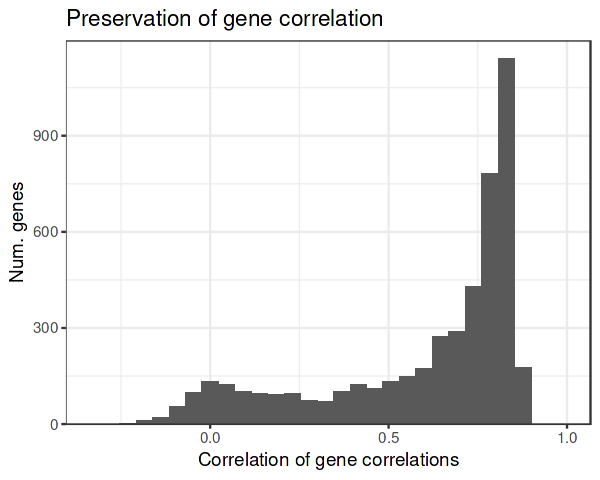

In [29]:
options(repr.plot.width=5, repr.plot.height=4)

cor_cors <- estimate_correlation_preservation(sos$Xenium[['RNA']]$data, sos$scRNAseq[['RNA']]$data)
plot_correlation_preservation(cor_cors)

In [30]:
exclude_genes <- names(cor_cors)[cor_cors < 0.5]

In [31]:
cont_infos <- lapply(sos, \(so) {
  estimate_contamination_scores_seurat(
      sos$scRNAseq, so, cell.type.adj.mat=cell_type_adj_mat,
      p.c=0.25, signal.thres=0.6, min.expr.frac=0.05,
      exclude.genes=exclude_genes, adjust=TRUE
  )
})

Warning message in estimate_contamination_scores(cm.rna = so.rna[["RNA"]]$counts, :
“Some genes not found in both cm.rna and cm.spatial, 4912 genes left”
Warning message in estimate_contamination_scores(cm.rna = so.rna[["RNA"]]$counts, :
“Some genes not found in both cm.rna and cm.spatial, 4912 genes left”
Warning message in estimate_contamination_scores(cm.rna = so.rna[["RNA"]]$counts, :
“Some genes not found in both cm.rna and cm.spatial, 4912 genes left”
Warning message in estimate_contamination_scores(cm.rna = so.rna[["RNA"]]$counts, :
“Some genes not found in both cm.rna and cm.spatial, 4912 genes left”


In [32]:
names(sos)

[1] "Baysor"   "BIDCell"  "ProSeg"   "Xenium"   "scRNAseq"

### Distributions

In [37]:
y_max <- 0.5
admix_score_df <- names(cont_infos) %>% lapply(\(tn) {
    cont_infos[[tn]]$doublet.scores %>%
        {data.frame(scores=., cell_type=sos[[tn]]$cell_type[names(.)], cell=names(.), dataset=tn)}
}) %>% bind_rows() %>% mutate(scores=pmin(scores, y_max)) %>%
    mutate(dataset=factor(dataset, levels=names(sos)))

Warning message:
“Removed 1099 rows containing non-finite outside the scale range (`stat_boxplot()`).”


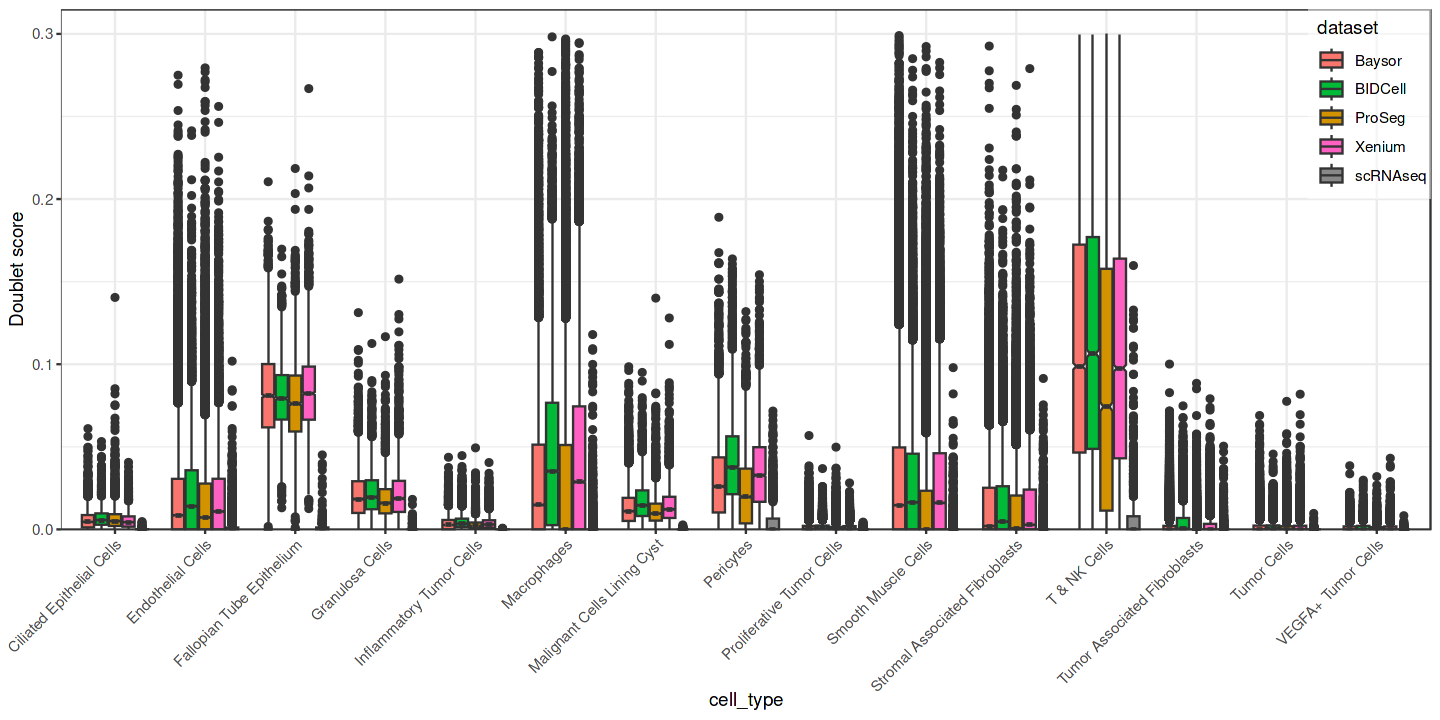

In [38]:
options(repr.plot.width=12, repr.plot.height=6)

gg <- ggplot(admix_score_df) +
  geom_boxplot(aes(x=cell_type, y=scores, fill=dataset), notch=TRUE) +
  scale_y_continuous(limits=c(0.0, 0.3), expand=c(0, 0, 0.05, 0)) +
  scale_fill_manual(values=palette) +
  ylab('Doublet score') + theme_legend(position=c(1, 1)) +
  theme(axis.text.x=element_text(angle=45, vjust=1, hjust=1))

suppressMessages(print(gg))

## Compute scores on cleaned data

**WARNING:** Here you need to run OC_per_seg_corrections.R to get the corrected results per segmentation.

In [40]:
## computing scores for the corrected datasets as well
# loadings the cleaned data as well
base_dir <- CachePath('OC_scaled_dat6/')
k <- 20
methods_test <- c('baysor', 'bidcell','proseg','xenium')
all_df_cln <- lapply(methods_test,function(method) {
    df_cln <- readRDS(file=paste0(base_dir,'df_k',k,'_cln_',method,'.rds'))
    df_cln <- df_cln[df_cln$celltype %in% common_cell_types,]
    return(df_cln)
})
shared_genes2 <- sapply(all_df_cln, function(x) return(x$gene)) %>% Reduce(intersect, .)
shared_genes_all <- intersect(shared_genes,shared_genes2)
names(all_df_cln) <- paste0(methods_test,'_cln')

In [42]:
all_so_cln <- lapply(1:length(all_df_cln),function(df_cln_ndx) {
    print(df_cln_ndx)
    df_cln <- all_df_cln[[df_cln_ndx]]
    method <- names(all_df_cln)[df_cln_ndx]
    # make counts
    df_cln <- df_cln[df_cln$gene %in% shared_genes_all,]
    so <- get_counts_meta_seurat(df_cln,normalize=TRUE)
    so$sample <- method
    print('done')
    return(so)
})
names(all_so_cln) <- paste0(methods_test,'_cln')

[1] 1
[1] "done"
[1] 2
[1] "done"
[1] 3
[1] "done"
[1] 4
[1] "done"


In [43]:
sos2 <- lapply(sos,function(so){
    cm <- so[['RNA']]$counts[shared_genes_all,]
    meta <- so@meta.data
    so <- CreateSeuratObject(cm,meta.data=meta)
    so <- NormalizeData(so)
    # so <- process_seurat(so)
    return(so)
})

sos3 <- c(sos2, all_so_cln)
sos3$scRNAseq <- so_rna

In [46]:
sos3 %<>% lapply(\(so) subset(so, cells=colnames(so)[so$cell_type %in% unique(common_cell_types)]))

In [48]:
names(sos3)

[1] "Baysor"      "BIDCell"     "ProSeg"      "Xenium"      "scRNAseq"   
[6] "baysor_cln"  "bidcell_cln" "proseg_cln"  "xenium_cln"

In [68]:
cont_infos <- lapply(sos3, \(so) {
  estimate_contamination_scores_seurat(
      sos$scRNAseq, so, cell.type.adj.mat=cell_type_adj_mat,
      p.c=0.25, signal.thres=0.4, min.expr.frac=0.05,
      exclude.genes=exclude_genes, adjust=TRUE
  )
})


Warning message in estimate_contamination_scores(cm.rna = so.rna[["RNA"]]$counts, :
“Some genes not found in both cm.rna and cm.spatial, 4912 genes left”
Warning message in estimate_contamination_scores(cm.rna = so.rna[["RNA"]]$counts, :
“Some genes not found in both cm.rna and cm.spatial, 4912 genes left”
Warning message in estimate_contamination_scores(cm.rna = so.rna[["RNA"]]$counts, :
“Some genes not found in both cm.rna and cm.spatial, 4912 genes left”
Warning message in estimate_contamination_scores(cm.rna = so.rna[["RNA"]]$counts, :
“Some genes not found in both cm.rna and cm.spatial, 4912 genes left”
Warning message in estimate_contamination_scores(cm.rna = so.rna[["RNA"]]$counts, :
“Some genes not found in both cm.rna and cm.spatial, 4912 genes left”
Warning message in estimate_contamination_scores(cm.rna = so.rna[["RNA"]]$counts, :
“Some genes not found in both cm.rna and cm.spatial, 4912 genes left”
Warning message in estimate_contamination_scores(cm.rna = so.rna[["RNA"]]$co

In [79]:
admix_score_df <- names(cont_infos) %>% lapply(\(tn) {
    cont_infos[[tn]]$doublet.scores %>%
        {data.frame(scores=., cell_type=sos3[[tn]]$cell_type[names(.)], cell=names(.), dataset=tn)}
}) %>% bind_rows()

In [80]:
head(admix_score_df)

,scores,cell_type,cell,dataset
,<dbl>,<chr>,<chr>,<chr>
Baysor_human_ovarian_cancer_CR0be684987-2072,0.000000000,Ciliated Epithelial Cells,Baysor_human_ovarian_cancer_CR0be684987-2072,Baysor
Baysor_human_ovarian_cancer_CR0be684987-2094,0.003334784,Ciliated Epithelial Cells,Baysor_human_ovarian_cancer_CR0be684987-2094,Baysor
Baysor_human_ovarian_cancer_CR0be684987-2335,0.005883038,Ciliated Epithelial Cells,Baysor_human_ovarian_cancer_CR0be684987-2335,Baysor
Baysor_human_ovarian_cancer_CR0be684987-2355,0.018637661,Ciliated Epithelial Cells,Baysor_human_ovarian_cancer_CR0be684987-2355,Baysor
Baysor_human_ovarian_cancer_CR0be684987-2375,0.001768224,Ciliated Epithelial Cells,Baysor_human_ovarian_cancer_CR0be684987-2375,Baysor
Baysor_human_ovarian_cancer_CR0be684987-2696,0.016963277,Ciliated Epithelial Cells,Baysor_human_ovarian_cancer_CR0be684987-2696,Baysor


In [82]:
plot_ct_av_norm_scores_seg <- function(ref_dataset,scores_final_df,seg_unique,
                                       trim_level=NULL,min_mean_thresh=1e-3,
                                       y_max=NULL) {

    ## selecting the same cells from orig vs cln for each segmentation
    scores_final_df$cell2 <- sapply(scores_final_df$cell,function(x){
      tmp <- strsplit(x,split='_')[[1]]
      tmp <- tmp[[length(tmp)]]
      if (substr(tmp,1,4)=='cell') {
          tmp <- substr(tmp,5,nchar(tmp))
      }
      if (substr(tmp,1,1)!='C') {
        tmp <- paste0('C',tmp)
      }
      return(tmp)
    })

    scores_final_df2 <- list()
    for (seg in seg_unique) {
        if (strsplit(ref_dataset,split=' ')[[1]][[1]]==seg) {
            scores_sub1 <- scores_final_df[scores_final_df$dataset==ref_dataset,]
        } else {
            scores_sub1 <- scores_final_df[scores_final_df$dataset==seg,]
        }
      scores_sub2 <- scores_final_df[scores_final_df$dataset==paste0(seg,'_cln'),]

      cells_int <- intersect(scores_sub1$cell2,scores_sub2$cell2)
      scores_sub1 <- scores_sub1[scores_sub1$cell2 %in% cells_int,]
      scores_sub2 <- scores_sub2[scores_sub2$cell2 %in% cells_int,]
      scores_seg <- rbind.data.frame(scores_sub1,scores_sub2)
      scores_final_df2[[seg]] <- scores_seg
    }

    scores_final_df2[['scRNAseq']] <- scores_final_df[scores_final_df$dataset=='scRNAseq',]
    scores_final_df <- do.call(rbind.data.frame,scores_final_df2)

  if (!is.null(trim_level)) {
    # now computing trimmed average scores per cell type
    doublet_df_agg <- scores_final_df %>%
      group_by(dataset, cell_type) %>%
      summarise(scores = mean(scores, trim=trim_level, na.rm = TRUE))
  } else {
    doublet_df_agg <- scores_final_df %>%
      group_by(dataset, cell_type) %>%
      summarise(scores = mean(scores, na.rm = TRUE))
  }

  meta <- unique(scores_final_df[,c('dataset','method','cln_status','cell_type')])
  rownames(meta) <- paste0(meta$dataset,'_',meta$cell_type)
  meta <- meta[,c(2,3)]

  doublet_df_agg <- as.data.frame(doublet_df_agg)
  rownames(doublet_df_agg) <- paste0(doublet_df_agg$dataset,'_',doublet_df_agg$cell_type)
  doublet_df_agg <- cbind.data.frame(doublet_df_agg,meta[rownames(doublet_df_agg),])

  norm_scores <- doublet_df_agg %>% filter(dataset==ref_dataset) %$% setNames(scores, cell_type)
  doublet_df_agg <- doublet_df_agg %>%
    filter(norm_scores[cell_type] > min_mean_thresh) %>%
    mutate(scores = scores / norm_scores[cell_type])

  y_min <- 0
  if (is.null(y_max)) {
      y_max <- max(doublet_df_agg$scores)
      print(y_max)
  }

  p <- ggplot(doublet_df_agg) +
    geom_boxplot(aes(x=cln_status, y=scores),position = position_dodge(), outliers=FALSE) +
    geom_point(aes(x=cln_status, y=scores, color=cell_type),position = position_jitterdodge(jitter.width = 0.075,   # jitter within each dodge-group
                                                                                                         dodge.width = 0.8)) +
    facet_wrap(. ~ method,scales = "free_x",nrow = 1,strip.position = "bottom") +
    coord_cartesian(ylim = c(y_min,y_max)) +
    theme_legend(position=c(1, 1)) +
    geom_hline(yintercept=1,color='red',linetype='dashed') +
    guides(color=guide_legend("Cell type",keywidth=0.1,
                              keyheight=0.15,
                              default.unit="inch")) +
    # scale_fill_manual(values = c("gray98","gray80",'black')) +
    xlab('') +
    ylab('Mean P_admix method/ref') +
    theme_bw() +
    theme(
        panel.spacing = unit(0, "lines"),         # removes spacing between panels
        # strip.background = element_blank(),       # removes strip background color
        panel.border = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1),
        strip.placement = "outside"
    )

  return(p)
}

In [83]:
unique(admix_score_df$dataset)

[1] "Baysor"      "BIDCell"     "ProSeg"      "Xenium"      "scRNAseq"   
[6] "baysor_cln"  "bidcell_cln" "proseg_cln"  "xenium_cln"

In [84]:
admix_score_df$dataset <- factor(admix_score_df$dataset,levels=c('Xenium','Baysor','BIDCell','ProSeg','xenium_cln','baysor_cln','bidcell_cln','proseg_cln','scRNAseq'))
levels(admix_score_df$dataset) <- c('Xenium (ref)','Baysor','BIDCell','ProSeg','Xenium_cln','Baysor_cln','BIDCell_cln','ProSeg_cln','scRNAseq')
admix_score_df$method <- sapply(as.character(admix_score_df$dataset),function(x){
    if (x %in% c('Xenium (ref)','Xenium_cln')) {
        return('Xenium (ref)')
    } else if (x %in% c('Baysor','Baysor_cln')) {
        return('Baysor')
    } else if (x %in% c('BIDCell','BIDCell_cln')) {
        return('BIDCell')
    } else if (x %in% c('ProSeg','ProSeg_cln'))  {
        return('ProSeg')
    } else if (x=='scRNAseq') {
        return('scRNAseq')
    }
})
admix_score_df$cln_status <- sapply(admix_score_df$dataset,function(x){
    if (x %in% c('Xenium_cln','Baysor_cln','BIDCell_cln','ProSeg_cln')) {
        return('cleaned')
    } else if (x=='scRNAseq') {
        return('scRNAseq')
    } else {
        return('unclean')
    }
})

In [85]:
admix_score_df$cln_status <- factor(admix_score_df$cln_status,levels=c('unclean','cleaned','scRNAseq'))

In [86]:
admix_score_df$method <- factor(admix_score_df$method,levels=c('Xenium (ref)','Baysor','BIDCell','ProSeg','scRNAseq'))

`summarise()` has grouped output by 'dataset'. You can override using the `.groups` argument.


[1] 1.97408


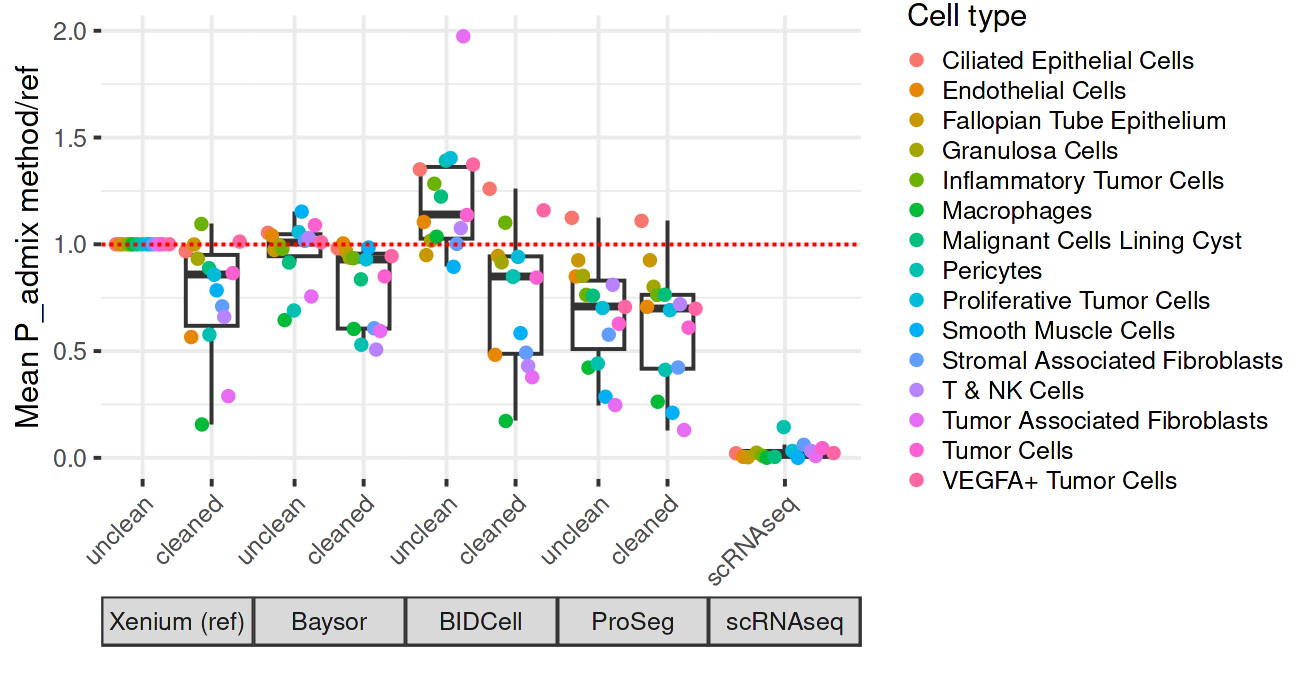

In [87]:
options(repr.plot.width = 6.5, repr.plot.height = 3.5, repr.plot.res = 200)

p1 <- plot_ct_av_norm_scores_seg('Xenium (ref)',admix_score_df,seg_unique=c('Xenium','Baysor','BIDCell','ProSeg'),trim_level=.1,min_mean_thresh=1e-3)
p1

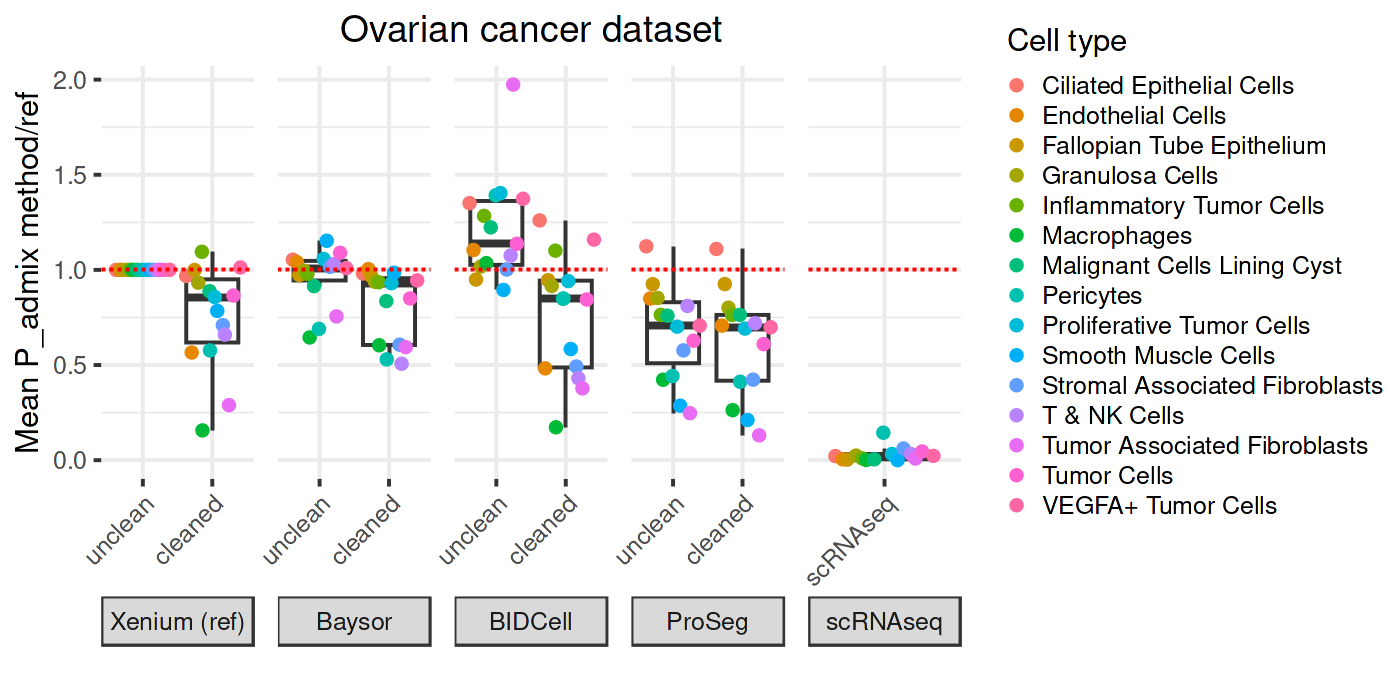

In [98]:
options(repr.plot.width = 7, repr.plot.height = 3.5, repr.plot.res = 200)
p_final <- p1 + ggtitle('Ovarian cancer dataset') + theme(plot.title = element_text(hjust = 0.5),
                                               panel.spacing = unit(.6, "lines"))
p_final

In [99]:
pdf(OutputPath("OC_seg_compare.pdf"), useDingbats=FALSE, width=7, height=3.5)
p_final
dev.off()

png 
  2